# TP : Variational autoencoder

In this practical session, our objective is to implement and to train from scratch a variational auto-encoder to produce images of digits using the dataset MNIST.

## 1: MNIST Dataset

The script below loads the training images and the test images of MNIST dataset.

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
tensor_transform = transforms.ToTensor()
dataset_train = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)
dataset_test = datasets.MNIST(root="./data", train=False, download=True, transform=tensor_transform)

Let us display some training images.

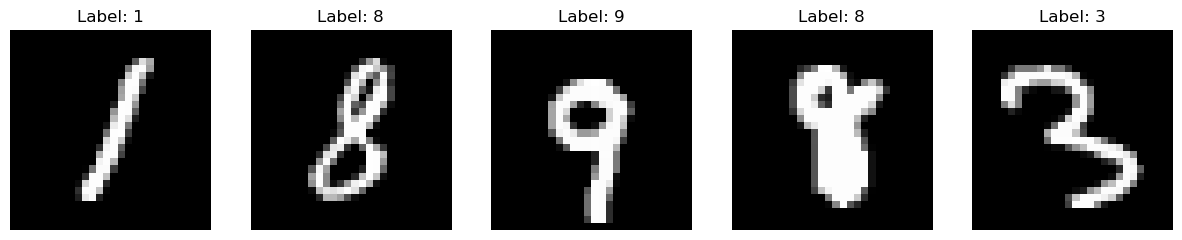

In [3]:
trainloader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
images, labels = next(iter(trainloader))
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')
plt.show()

## 2: Auto-encoder model

We start by implementing an auto-encoder for learning a compressed representation of each image of the dataset.

**Question 1**: Using the template class AutoEncoder, implement an autoencoder architecture compressing the 28x28 MNIST images into a 9-dimensional latent space and reconstruct them. The encoder uses fully connected layers with ReLU activations for hidden layers and reduce the dimension in the following way : 28 x 28 = 784 -> 128 -> 64 -> 36 -> 18 -> 9. The decoder mirrors the encoder architecture. Its final layer uses a sigmoid non-linearity.

In [4]:
class AutoEncoder(nn.Module):
    
    """
    Autoencoder for MNIST digit reconstruction.

    This model compresses 28x28 MNIST images into a 9-dimensional latent space
    and reconstructs them. The architecture uses fully connected layers with ReLU
    activations for hidden layers and Sigmoid for the output layer.

    Attributes:
        encoder (nn.Sequential): Encoder network to compress input images.
        decoder (nn.Sequential): Decoder network to reconstruct images from latent space.
    """

    def __init__(self):
        
        """
        Initializes the autoencoder with encoder and decoder networks
        """
        super(AutoEncoder, self).__init__()

        # Encoder: Compresses the input image (784) → 9-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # 784 → 128
            nn.ReLU(),
            nn.Linear(128, 64),      # 128 → 64
            nn.ReLU(),
            nn.Linear(64, 36),       # 64 → 36
            nn.ReLU(),
            nn.Linear(36, 18),       # 36 → 18
            nn.ReLU(),
            nn.Linear(18, 9)         # 18 → 9 (latent space)
        )

        # Decoder: Reconstructs the image from latent space (9 → 784)
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),        # 9 → 18
            nn.ReLU(),
            nn.Linear(18, 36),       # 18 → 36
            nn.ReLU(),
            nn.Linear(36, 64),       # 36 → 64
            nn.ReLU(),
            nn.Linear(64, 128),      # 64 → 128
            nn.ReLU(),
            nn.Linear(128, 28 * 28), # 128 → 784
            nn.Sigmoid()             # Output between 0 and 1
        )

    def forward(self, x):
        
        """
        Forward pass of the autoencoder.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 784).

        Returns:
            torch.Tensor: Reconstructed image tensor of shape (batch_size, 784).
        """
        encoded = self.encoder(x)   # Encode input
        decoded = self.decoder(encoded)  # Decode latent representation
        return encoded, decoded

### Training the model

**Question 2**: complete the following script to train the model.

In [5]:
ae = AutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-8)

In [ ]:
epochs = 20
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae.to(device)

for epoch in range(epochs):
    for images, _ in trainloader:
        images = images.view(-1, 28 * 28).to(device)

        _, reconstructed = ae.forward(images)
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 1/20, Loss: 0.016351
Epoch 2/20, Loss: 0.017782
Epoch 3/20, Loss: 0.018329
Epoch 4/20, Loss: 0.017939
Epoch 5/20, Loss: 0.018748
Epoch 6/20, Loss: 0.020712


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing the model

The following script checks if the auto-encoder performs the reconstruction properly.

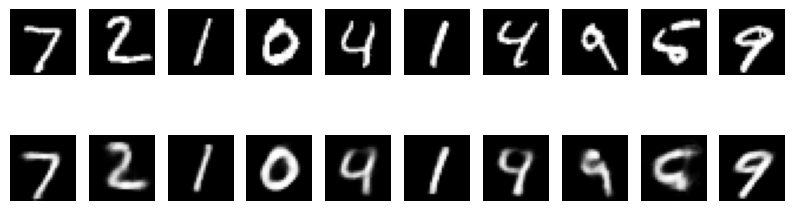

In [8]:
ae.eval()
testloader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)
dataiter = iter(testloader)
images, _ = next(dataiter)

images = images.view(-1, 28 * 28).to(device)
_, reconstructed = ae(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

## 3: Variational Auto-encoder

We can now start with the implementation of the variational auto-encoder. The encoder uses fully connected layers with ReLU activations for the hidden layers and reduce the dimension in the following way : 28 x 28 = 784 -> 128 -> 64 -> 36. The final layer of the encoder predicts the mean (dim=9) and the log-variance (dim=9) of the distribution of the latent variable. The decoder mirrors the encoder architecture. Its final layer uses a sigmoid non-linearity.

**Question 3**: Complete the implementation of the VAE using the template of the class VAE.

In [9]:
class VAE(nn.Module):
    
    """
    Variational Autoencoder (VAE) for MNIST digit reconstruction.
    This model compresses 28x28 MNIST images into a 9-dimensional latent space,
    using a probabilistic approach to generate new samples.
    Attributes:
        encoder (nn.Sequential): Encoder network to output mean and log-variance of latent distribution.
        decoder (nn.Sequential): Decoder network to reconstruct images from latent space.
        latent_dim (int): Dimensionality of the latent space.
    """

    def __init__(self, latent_dim=9):
        """
        Initializes the VAE with encoder and decoder networks.
        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: Maps input to mean and log-variance of latent distribution
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # 784 → 128
            nn.ReLU(),
            nn.Linear(128, 64),      # 128 → 64
            nn.ReLU(),
            nn.Linear(64, 36),       # 64 → 36
            nn.ReLU(),
        )
        # Mean and log-variance layers
        self.fc_mu = nn.Linear(36, latent_dim)  # 36 → latent_dim (mean)
        self.fc_var = nn.Linear(36, latent_dim) # 36 → latent_dim (log-variance)

        # Decoder: Reconstructs the image from latent space
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 18),      # latent_dim → 18
            nn.ReLU(),
            nn.Linear(18, 36),              # 18 → 36
            nn.ReLU(),
            nn.Linear(36, 64),              # 36 → 64
            nn.ReLU(),
            nn.Linear(64, 128),             # 64 → 128
            nn.ReLU(),
            nn.Linear(128, 28 * 28),        # 128 → 784
            nn.Sigmoid()                    # Output between 0 and 1
        )

    def encode(self, x):
        """
        Encodes the input into mean and log-variance of the latent distribution
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 784)
            
        Returns:
            tuple: (mu, log_var), each of shape (batch_size, latent_dim)
        """
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var)
        
        Args:
            mu (torch.Tensor): Mean of the latent distribution
            log_var (torch.Tensor): Log-variance of the latent distribution
            
        Returns:
            torch.Tensor: Sampled latent vector of shape (batch_size, latent_dim)
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """
        Decodes the latent vector into a reconstructed image
        
        Args:
            z (torch.Tensor): Latent vector of shape (batch_size, latent_dim)
            
        Returns:
            torch.Tensor: Reconstructed image tensor of shape (batch_size, 784)
        """
        return self.decoder(z)

    def forward(self, x):
        """
        Forward pass of the VAE
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 784)
            
        Returns:
            tuple: (reconstructed image, mean, log-variance)
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
        

def vae_loss(recon_x, x, mu, log_var):
    
    """
    Computes the VAE loss (reconstruction loss + KL divergence)
    
    Args:
        recon_x (torch.Tensor): Reconstructed image tensor
        x (torch.Tensor): Original input tensor
        mu (torch.Tensor): Mean of the latent distribution
        log_var (torch.Tensor): Log-variance of the latent distribution
        
    Returns:
        torch.Tensor: Total loss (reconstruction loss + KL divergence)
    """
    
    # Reconstruction loss (binary cross-entropy)
    #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD

## Training the VAE

In [10]:
vae = VAE(latent_dim=9)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 30
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

for epoch in range(epochs):
    for images, _ in trainloader:
        images = images.view(-1, 28 * 28).to(device)

        # Forward pass
        recon_images, mu, log_var = vae(images)
        loss = vae_loss(recon_images, images, mu, log_var)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    

Epoch 1/30, Loss: 1344.102051
Epoch 2/30, Loss: 1212.453613
Epoch 3/30, Loss: 1198.083252
Epoch 4/30, Loss: 1137.327148
Epoch 5/30, Loss: 1052.245605
Epoch 6/30, Loss: 992.095215
Epoch 7/30, Loss: 1126.767944
Epoch 8/30, Loss: 1056.848389
Epoch 9/30, Loss: 977.683472
Epoch 10/30, Loss: 1072.145752
Epoch 11/30, Loss: 1210.845215
Epoch 12/30, Loss: 1083.077026
Epoch 13/30, Loss: 1098.588745
Epoch 14/30, Loss: 1222.072510
Epoch 15/30, Loss: 817.567261
Epoch 16/30, Loss: 949.898010
Epoch 17/30, Loss: 1025.309204
Epoch 18/30, Loss: 1002.401733
Epoch 19/30, Loss: 1083.056519
Epoch 20/30, Loss: 1085.791992
Epoch 21/30, Loss: 1024.041138
Epoch 22/30, Loss: 954.038940
Epoch 23/30, Loss: 1057.582764
Epoch 24/30, Loss: 1142.710571
Epoch 25/30, Loss: 1083.612671
Epoch 26/30, Loss: 991.649109
Epoch 27/30, Loss: 945.601196
Epoch 28/30, Loss: 1086.857422
Epoch 29/30, Loss: 1007.876648
Epoch 30/30, Loss: 984.765747


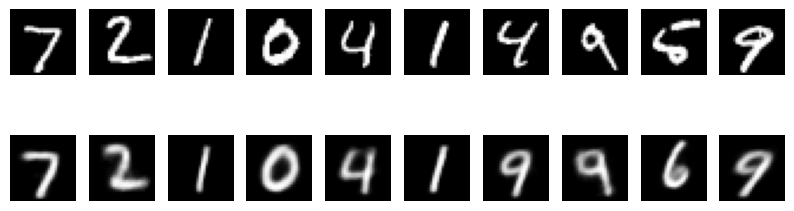

In [11]:
vae.eval()
dataiter = iter(testloader)
images, _ = next(dataiter)

images = images.view(-1, 28 * 28).to(device)
reconstructed, _, _ = vae(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

## 4. Interpolation in the latent space

Here, our goal is to leverage autoencoder (AE) and variational autoencoder (VAE) architectures to perform image interpolation. Unlike traditional pixel-based interpolation methods—which often produce blurry or unrealistic transitions—our approach focuses on interpolating directly in the latent space. This method preserves the semantic structure of the data, ensuring that the generated intermediate images remain meaningful and coherent. The use of VAEs adds a probabilistic framework, ensuring that the latent space is well-structured and that interpolations remain within the distribution of the training data.

The following method interpolates between two images directly in the pixels space.

In [12]:
def interpolate_in_image_space(img1, img2, num_steps=10):
    
    """
    Interpolates between two images in pixel space.

    Args:
        img1 (torch.Tensor): First image tensor (shape: [1, 28, 28] or [28, 28]).
        img2 (torch.Tensor): Second image tensor (shape: [1, 28, 28] or [28, 28]).
        num_steps (int): Number of interpolation steps.
    Returns:
        list: Interpolated images as tensors.
    """
    interpolated_images = []
    for alpha in torch.linspace(0, 1, num_steps):
        # Linear interpolation: img1 + alpha * (img2 - img1)
        interpolated_img = img1 + alpha * (img2 - img1)
        interpolated_images.append(interpolated_img)
    return interpolated_images

**Question 4**: Complete the implementation of the two following functions for performing the interpolation in the latent space of the VAE and of the autoencoder

In [13]:
def interpolate_with_vae(vae, img1, img2, num_steps=10):
    
    """
    Interpolates between two images in the latent space.

    Args:
        vae (VAE): Trained VAE model.
        img1 (torch.Tensor): First image tensor (flattened).
        img2 (torch.Tensor): Second image tensor (flattened).
        num_steps (int): Number of interpolation steps.
    Returns:
        list: Interpolated images as tensors.
    """
    vae.eval()
    with torch.no_grad():

        # Flatten and move to device
        img1_flat = img1.view(1, -1).to(device)
        img2_flat = img2.view(1, -1).to(device)
        
        # Encode both images
        mu1, log_var1 = vae.encode(img1_flat)
        mu2, log_var2 = vae.encode(img2_flat)
        z1 = vae.reparameterize(mu1, log_var1)
        z2 = vae.reparameterize(mu2, log_var2)
        
        # Linearly interpolate in latent space
        interpolated_images = []
        for alpha in torch.linspace(0, 1, num_steps):
            # Interpolate between mu1 and mu2
            z = z1 + alpha * (z2 - z1)
            # Decode the interpolated latent vector
            interpolated_img = vae.decode(z)
            interpolated_images.append(interpolated_img.squeeze().cpu())

    return interpolated_images


In [14]:
def interpolate_with_ae(ae, img1, img2, num_steps=10):
    
    """
    Interpolates between two images in the latent space with an auto-encoder.

    Args:
        ae (AE): Trained AE model.
        img1 (torch.Tensor): First image tensor (flattened).
        img2 (torch.Tensor): Second image tensor (flattened).
        num_steps (int): Number of interpolation steps.
    Returns:
        list: Interpolated images as tensors.
    """
    ae.eval()
    with torch.no_grad():

        # Flatten and move to device
        img1_flat = img1.view(1, -1).to(device)
        img2_flat = img2.view(1, -1).to(device)
        
        # Encode both images
        z1, _ = ae(img1_flat)
        z2, _ = ae(img2_flat)
        
        # Linearly interpolate in latent space
        interpolated_images = []
        for alpha in torch.linspace(0, 1, num_steps):
            # Interpolate between mu1 and mu2
            z = z1 + alpha * (z2 - z1)
            # Decode the interpolated latent vector
            interpolated_img = ae.decoder(z)
            interpolated_images.append(interpolated_img.squeeze().cpu())

    return interpolated_images

The following script interpolates between two images selected randomly from the test dataset

In [20]:
random_indices = torch.randperm(len(dataset_test))[:2]
img1, _ = dataset_test[random_indices[0]]
img2, _ = dataset_test[random_indices[1]]
interpolated_images = interpolate_in_image_space(img1, img2, num_steps=10)
interpolated_vae = interpolate_with_vae(vae, img1, img2, num_steps=10)
interpolated_ae = interpolate_with_ae(ae, img1, img2, num_steps=10)

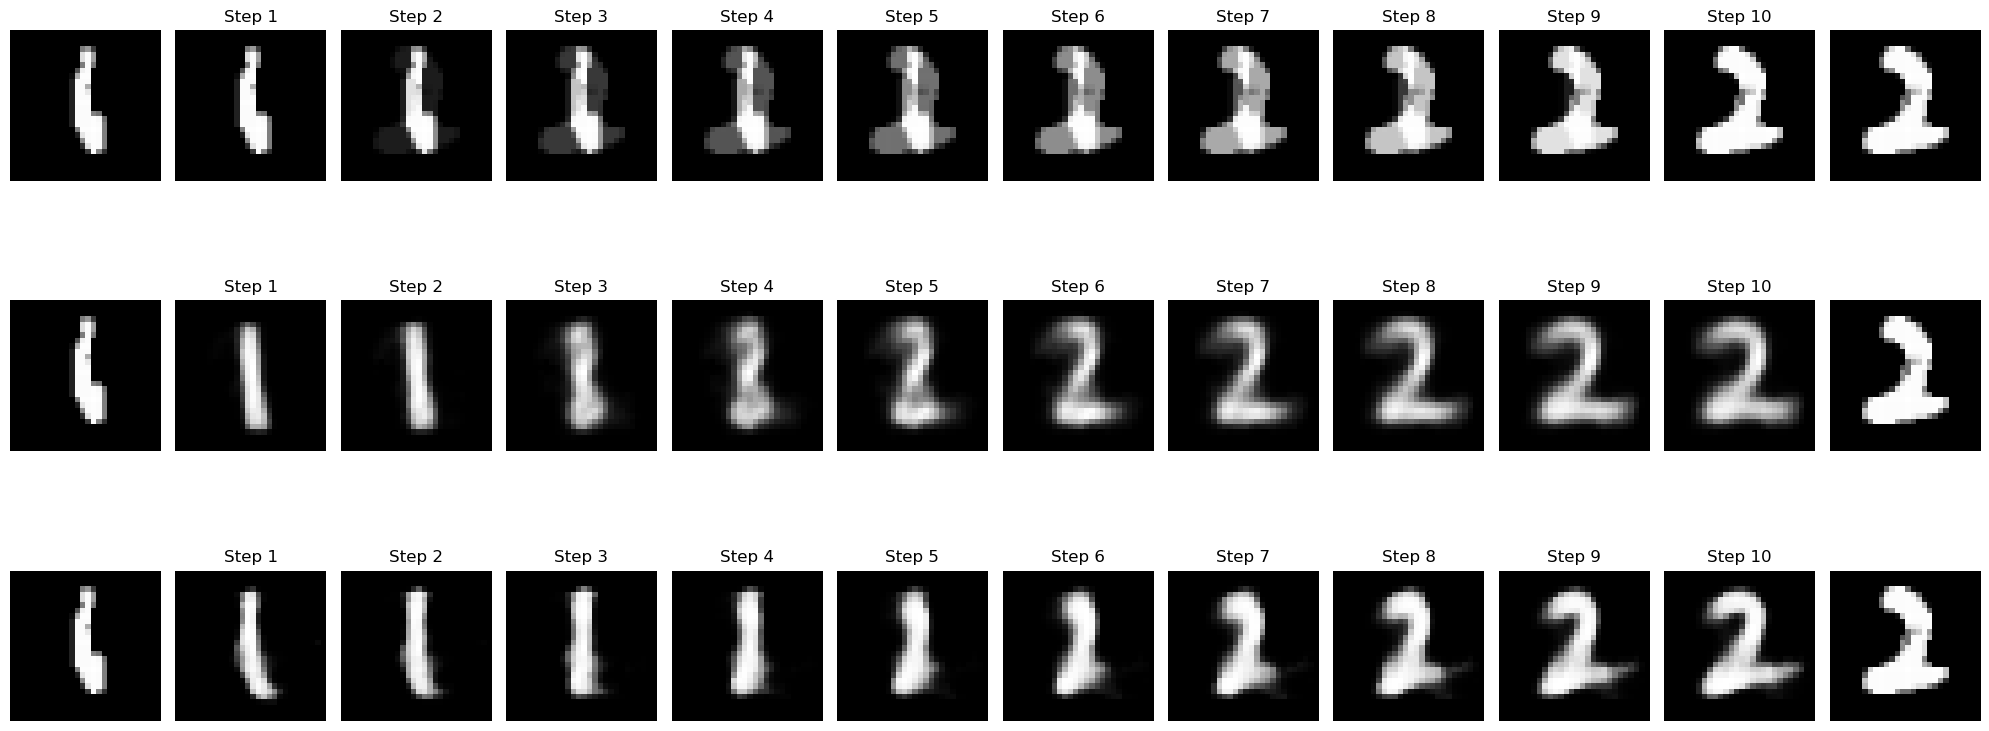

In [21]:
num_steps = len(interpolated_images)
fig, axes = plt.subplots(3, num_steps + 2, figsize=(20, 9))

# Plot original images in all rows
for row in range(3):
    axes[row, 0].imshow(img1.cpu().numpy().reshape(28, 28), cmap='gray')
    axes[row, 0].axis('off')
    axes[row, -1].imshow(img2.cpu().numpy().reshape(28, 28), cmap='gray')
    axes[row, -1].axis('off')

# Plot image space interpolation (first row)
for i, img in enumerate(interpolated_images):
    axes[0, i+1].imshow(img.numpy().reshape(28, 28), cmap='gray')
    axes[0, i+1].set_title(f'Step {i+1}')
    axes[0, i+1].axis('off')

# Plot VAE interpolation (second row)
for i, img in enumerate(interpolated_vae):
    axes[1, i+1].imshow(img.numpy().reshape(28, 28), cmap='gray')
    axes[1, i+1].set_title(f'Step {i+1}')
    axes[1, i+1].axis('off')

# Plot AE interpolation (third row)
for i, img in enumerate(interpolated_ae):
    axes[2, i+1].imshow(img.numpy().reshape(28, 28), cmap='gray')
    axes[2, i+1].set_title(f'Step {i+1}')
    axes[2, i+1].axis('off')
    # Add row labels
    axes[0, 0].set_ylabel('Image Space', fontsize=12)
    axes[1, 0].set_ylabel('VAE', fontsize=12)
    axes[2, 0].set_ylabel('AE', fontsize=12)

plt.tight_layout()
plt.show()